Import necessary libraries for text processing and machine learning.

In [15]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.cluster import KMeans
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

Load the dumped data from database into pandas dataframe

In [16]:
msg_df_all = pd.read_csv("repo_issue_messages.csv",error_bad_lines=False,delimiter=';')
msg_df_all.head()

,repo_id,issue_id,msg_text,issue_title
0,25807,349194,JavaDoc.\n,DATAKV-290 - Synchronize creation of keyspace map
1,25807,349194,JavaDoc.\n,DATAKV-290 - Synchronize creation of keyspace map
2,25857,371888,"Fixed , thanks.\n",Remove gpperfmon
3,25857,371888,Woohoo!!! nice\n,Remove gpperfmon
4,25872,366755,Yup. Tests added!,Add --redirect-schema flag to gprestore


The function to perform text preprocessing. The function takes collection of sentences as input and outputs stemmed tokens as output. Before tokenization, all the texts are converted to lower case, non-alphabet characters are filtered out and @ mentions are removed. Tokeniztion converts text into list of tokens and stemmization reduces word to its stem (lemma) form. 

In [17]:
def preprocess_and_tokenize(text):
    text= text.lower()
    text =  re.sub(r'[@]\w+','',text)
    text =  re.sub(r'[^A-Za-z]+', ' ', text)
    
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token)>1]
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [18]:
preprocess_and_tokenize(msg_df_all['msg_text'][4])

['yup', 'test', 'ad']

Define a function to return tfidf matrix from list of documents. General stop words in English are ignored. Also, there can be corpus specific stop words, which are the terms that have a document frequency strictly higher than the given threshold, set by max_df parameter. Similarly uncommon words are filtered by min_df parameter. max_features specifies the size of vocabulary. We also need to define upper and lower values for n_gram range. For e.g. (1,2) would mean both unigram and bigram are considered.

In [19]:
def get_tf_idf_matrix(text_list, max_df, max_features, min_df, ngram_range):
    tfidf_vectorizer = TfidfVectorizer(max_df = max_df, max_features=max_features,
                                      min_df=min_df, stop_words='english',
                                      use_idf=True, tokenizer=preprocess_and_tokenize, ngram_range=ngram_range)
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_list)
    return tfidf_matrix, tfidf_vectorizer.get_feature_names()

In [ ]:
# tfidf_matrix, features = get_tf_idf_matrix(msg_df['msg_text'], MAX_DF, MAX_FEATURES, MIN_DF, NGRAM_RANGE)
# print(features)

Now, we have function to convert the comments (or groups of comments) into feature vectors. We can proceed to apply unsupervised learning methods
on the dataset. Kmeans clustering is one of the simplest yet effective technique for clustering the data points.

In [20]:
def cluster_and_label(feature_matrix, num_clusters):
    kmeans_model = KMeans(n_clusters=NUM_CLUSTERS)
    kmeans_model.fit(feature_matrix)
    return kmeans_model.labels_.tolist()
    

In [49]:
def visualize_labels_PCA(features, labels, num_components, title):
    
    labels_color_map = {}
    for label in labels:
        labels_color_map[label] = [list([x/255.0 for x in list(np.random.choice(range(256), size=3))])]
    low_dim_data = PCA(n_components=num_components).fit_transform(features)

    fig, ax = plt.subplots()

    for index, data in enumerate(low_dim_data):
        pca_comp_1, pca_comp_2 = data
        color = labels_color_map[labels[index]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color,label=labels[index])
        
    
    handles,labels = ax.get_legend_handles_labels()
    handles_label_dict = OrderedDict(zip(labels, handles))
    ax.legend(handles_label_dict.values(), handles_label_dict.keys() )
    
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

Let's get the comments data for particular repository

# Clustering Github Issues based on comments

In [22]:
repo_id = 28031
issue_id = 482972

msg_df = msg_df_all.loc[
    msg_df_all['repo_id'] == repo_id]

#Appending all messages within an issue, The step below groups together comments that belong to the same issue to form a document.
msg_df = msg_df.groupby('issue_id')['msg_text'].apply(','.join)
msg_df = msg_df.reset_index()

Define the parameters for vectorization and clustering

In [25]:
#vectorization
MAX_DF_LIST = [0.9, 0.85]
MIN_DF_LIST = [0.1, 0.2]
MAX_FEATURES = 1000
NGRAM_RANGE = (1,3)

#clustering
NUM_CLUSTERS = 4



Now, for the selected repositories perform the following operations <br>
1. Convert document into tfidf feature vectors <br>
2. Perform clustering to assign each data point(document) to a cluster using kmeans <br>
3. Reduce the dimensionality using Principal Component Analysis and visualize the clusters

MIN_DF=0.1 and MAX_DF=0.9


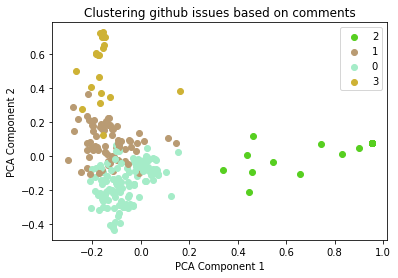

MIN_DF=0.2 and MAX_DF=0.9


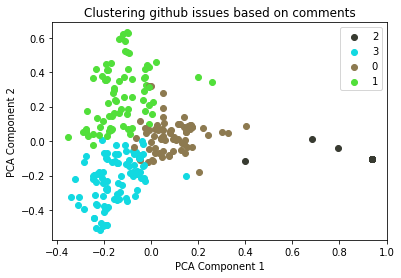

MIN_DF=0.1 and MAX_DF=0.85


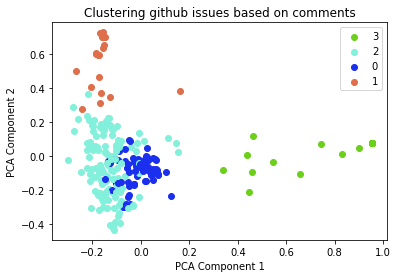

MIN_DF=0.2 and MAX_DF=0.85


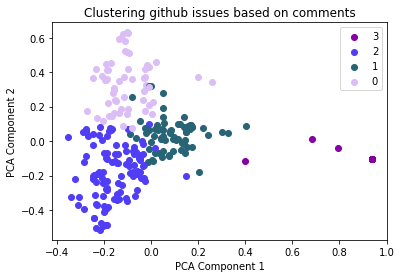

In [27]:
for MAX_DF in MAX_DF_LIST:
    for MIN_DF in MIN_DF_LIST:
        print("MIN_DF={} and MAX_DF={}".format(MIN_DF, MAX_DF))
        tfidf_matrix, features = get_tf_idf_matrix(msg_df['msg_text'], MAX_DF, MAX_FEATURES, MIN_DF, NGRAM_RANGE)
        #print(features)
        msg_df['cluster'] = cluster_and_label(tfidf_matrix, NUM_CLUSTERS)
        #print(msg_df.head())
        visualize_labels_PCA(tfidf_matrix.todense(), msg_df['cluster'], 2, "Clustering github issues based on comments")

# Anomaly Detection

Outlier detection can be performed across multiple levels. A comment thread belongs to an issue. <br>Comment as an outlier within a comment thread <br>Comment as an outlier within a repository <br>Comment Thread as an outlier within a repository.

There are different algorithms for anomaly detection available in scikit-learn library. Let's explore them one by one

In [30]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [60]:
repo_id = 28031
issue_id = 482972

msg_df = msg_df_all.loc[
    msg_df_all['repo_id'] == repo_id]
msg_df = msg_df.reset_index()

26
[ True  True  True ...  True  True  True]
4       This could also be similar to #2272 - my first...
6       > This could also be similar to #2272 - my fir...
7       @a4nowgh Velero runs `restic prune` every `7d`...
9       The above was test was performed with velero b...
25       I don't see any yaml set on velero v1.2.0 abo...
                              ...                        
2584    apiVersion: apps/v1\r\nkind: DaemonSet\r\nmeta...
2589    I'm not aware of any feature flags or any othe...
2597    @ashish-amarnath I checked the owner reference...
2610    apiVersion: apps/v1\r\nkind: DaemonSet\r\nmeta...
2615    I'm not aware of any feature flags or any othe...
Name: msg_text, Length: 202, dtype: object


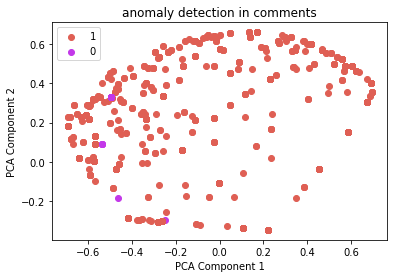

In [63]:
tfidf_matrix, features = get_tf_idf_matrix(msg_df['msg_text'], MAX_DF, MAX_FEATURES, MIN_DF, NGRAM_RANGE)

num_records = len(msg_df.index)
outliers_fraction = 0.01
num_outliers = int(outliers_fraction*num_records)
num_inliners = num_records - num_outliers
print(num_outliers)
svm_model = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)
pred = svm_model.fit(tfidf_matrix).predict(tfidf_matrix)
print(pred==1)
msg_df['anom'] = [0 if label==-1 else 1 for label in pred ] # model predicts -1 for anomalous data, converting it to 0
print(msg_df.loc[msg_df['anom']==0]['msg_text'])
visualize_labels_PCA(tfidf_matrix.todense(), msg_df['anom'], 2, "anomaly detection in comments")